## Create Dataset

### Create Data From Corpus

In [ ]:
#Dataset:
    #https://groups.inf.ed.ac.uk/switchboard/
    #Acquired by emailing the authors

In [153]:
import xml.etree.ElementTree as ET
import operator
import os

#Share path to dataset
path = 'swb/swb_nxt/xml/'

L = os.listdir(path+'syntax/')
L.sort()

L = [x.split('.')[:2] for x in L]

L2 = list(set([x[0] for x in L]))
L2.sort()

In [154]:
# L2 is the list of all speakers

In [155]:
%%time
#Parsing the XML file and recording the word, pos tag and durations
TERMINALS = {}
for i in L2:
    
    xmlfile = i
    xmlfileA = i + '.A.'
    xmlfileB = i + '.B.'
    
    TERMINALS[xmlfile+'A'] = {}
    TERMINALS[xmlfile+'B'] = {}

    #XML root name of speaker A
    terminalsA = ET.parse(path+'terminals/'+xmlfileA+'terminals.xml')
    terRootA = terminalsA.getroot()
    
    #XML root name of speaker B
    terminalsB = ET.parse(path+'terminals/'+xmlfileB+'terminals.xml')
    terRootB = terminalsB.getroot()
    
    nite = '{http://nite.sourceforge.net/}'

    
    set_id = 's'
    #Parse children
    for child in terRootA: 
        
        #If child is word
        if child.tag == 'word':
            
            if child.attrib[nite+'end'] not in ('non-aligned','n/a') and child.attrib[nite+'start'] not in ('non-aligned','n/a'):
                #Store information of word
                TERMINALS[xmlfile+'A'][child.attrib[nite+'id']] = [child.attrib['orth'].lower(), child.attrib['pos'],float(child.attrib[nite+'start']),float(child.attrib[nite+'end']),"fluent"]
            else:
                #Misaligned durations marked as -1, and ignored later
                TERMINALS[xmlfile+'A'][child.attrib[nite+'id']] = [child.attrib['orth'].lower(), child.attrib['pos'],-1,-1,"fluent"]

        #If child is not a word, store is as special (marked with $)
        else:
            TERMINALS[xmlfile+'A'][child.attrib[nite+'id']] = ['$' + child.tag, "$",-1,-1,"$"]

    #Same procedure is as A is followed for B
    for child in terRootB:
        if child.tag == 'word':
            if child.attrib[nite+'end'] not in ('non-aligned','n/a') and child.attrib[nite+'start'] not in ('non-aligned','n/a'):
                TERMINALS[xmlfile+'B'][child.attrib[nite+'id']] = [child.attrib['orth'].lower(), child.attrib['pos'],float(child.attrib[nite+'start']),float(child.attrib[nite+'end']),"fluent"]
            else:
                TERMINALS[xmlfile+'B'][child.attrib[nite+'id']] = [child.attrib['orth'].lower(), child.attrib['pos'],-1,-1,"fluent"]

        else:
            TERMINALS[xmlfile+'B'][child.attrib[nite+'id']] = ['$' + child.tag, "$",-1,-1,"$"]


CPU times: user 9.26 s, sys: 324 ms, total: 9.58 s
Wall time: 12.9 s


In [156]:
%%time
#Store disfluencies
DISFLUENCIES = {}
REPARAS = {}
for i in L2:
    
    xmlfileA = i+'.A.'
    xmlfileB = i+'.B.'
    xmlfile = i
    

    disfluencyA = ET.parse(path+'disfluency/'+xmlfileA+'disfluency.xml')
    dRootA = disfluencyA.getroot()
    
    disfluencyB = ET.parse(path+'disfluency/'+xmlfileB+'disfluency.xml')
    dRootB = disfluencyB.getroot()
    
    nite = '{http://nite.sourceforge.net/}'
    
    
    reparas = [] #Sorted pair of reparandum and repair
    rdm = {} #Store reparandums in this dict
    rp = {} #Store repair in this dict
    for dis in dRootA:
        
        if dis.tag == 'disfluency':
            a = []
            b = []
            for child in dis:

                if child.tag == 'reparandum':
                    for r in child.iter():
                        if r.tag == nite+'child':
                            rdm[r.attrib['href'].split('#')[1][3:-1]] = 1
                            a.append(r.attrib['href'].split('#')[1][3:-1])

                if child.tag == 'repair':
                    for r in child.iter():
                        if r.tag == 'disfluency':
                            for reparand in r:
                                if reparand.tag == 'reparandum':
                                    for r_child in reparand.iter():
                                        if 'href' in r_child.attrib:
                                            rdm[r_child.attrib['href'].split('#')[1][3:-1]] = 1
                                            a.append(r_child.attrib['href'].split('#')[1][3:-1])

                    for r in child.iter():
                        if r.tag == nite+'child':
                            if r.attrib['href'].split('#')[1][3:-1] not in rdm:
                                rp[r.attrib['href'].split('#')[1][3:-1]] = 1
                                b.append(r.attrib['href'].split('#')[1][3:-1])
            
            #Store sorted pairs of reparandum and repair
            reparas_ = []
            q = sorted(a, key=lambda x: float(x.split('_')[0][1:]) + 0.0001* float(x.split('_')[1]))
            if len(q) > 0:
                reparas_.append(q)
                
            q = sorted(b, key=lambda x: float(x.split('_')[0][1:]) + 0.0001* float(x.split('_')[1]))
            if len(q) > 0:
                reparas_.append(q)
                
            if len(reparas_) > 0:
                reparas.append(reparas_)
    
    REPARAS[xmlfileA] = reparas #Update the reparandums values into the REPARAS dict for speaker A
    
    reparas = [] #Sorted pair of reparandum and repair
                            
    for dis in dRootB:
        
        if dis.tag == 'disfluency':
            a = []
            b = []
            for child in dis:
                if child.tag == 'reparandum':
                    for r in child.iter():
                        if r.tag == nite+'child':
                            rdm[r.attrib['href'].split('#')[1][3:-1]] = 1
                            a.append(r.attrib['href'].split('#')[1][3:-1])

                if child.tag == 'repair':

                    for r in child.iter():
                        if r.tag == 'disfluency':
                            for reparand in r:
                                if reparand.tag == 'reparandum':
                                    for r_child in reparand.iter():
                                        if 'href' in r_child.attrib:
                                            rdm[r_child.attrib['href'].split('#')[1][3:-1]] = 1
                                            a.append(r_child.attrib['href'].split('#')[1][3:-1])

                    for r in child.iter():
                        if r.tag == nite+'child':
                            if r.attrib['href'].split('#')[1][3:-1] not in rdm:
                                rp[r.attrib['href'].split('#')[1][3:-1]] = 1
                                b.append(r.attrib['href'].split('#')[1][3:-1])

            #Store sorted pairs of reparandum and repair
            reparas_ = []
            q = sorted(a, key=lambda x: float(x.split('_')[0][1:]) + 0.0001* float(x.split('_')[1]))
            if len(q) > 0:
                reparas_.append(q)
                
            q = sorted(b, key=lambda x: float(x.split('_')[0][1:]) + 0.0001* float(x.split('_')[1]))
            if len(q) > 0:
                reparas_.append(q)
                
            if len(reparas_)> 0:
                reparas.append(reparas_)
                    
    REPARAS[xmlfileB] = reparas #Update the reparandums values into the REPARAS dict for speaker B
    
    DISFLUENCIES[xmlfile] = {} #Store DISFLUENCIES for conversations
    DISFLUENCIES[xmlfile]['repair'] = rp.keys() #Store all repairs for conversation
    DISFLUENCIES[xmlfile]['reparandum'] = rdm.keys() #Store all reparandums for conversation

CPU times: user 842 ms, sys: 17.7 ms, total: 859 ms
Wall time: 872 ms


In [157]:
#Create a label for each word, whether it is repair or reparandum
MARKER = {}
for i in DISFLUENCIES.keys():
    MARKER[i] = {}
    for k in DISFLUENCIES[i]['repair']:
        MARKER[i][k] = 'rp'
        
    for k in DISFLUENCIES[i]['reparandum']:
        MARKER[i][k] = 'rpdm'

In [158]:
#Create list of all contractions i.e. words like n't (don't, hasn't) or 's (it's, she's).
#This is important because GPT-2 needs contractions to not have spaces before it
        #For example, sentences should be structured as It's raining rather than It 's raining
contractions = []
for i in TERMINALS.keys():
    for k in TERMINALS[i]:
        if k in MARKER[i[:-1]]:
            TERMINALS[i][k][-1] = MARKER[i[:-1]][k]
        if TERMINALS[i][k][-1] == 'fluent' and TERMINALS[i][k][1] == 'UH':
            TERMINALS[i][k][-1] = 'filler'
            
        if "'" in TERMINALS[i][k][0]:
            contractions.append(TERMINALS[i][k][0])

contractions = set(contractions)

In [163]:
#Create a dictionary for each sentence, which contains all the word tags
SETS = {}

key = ''

for speaker in TERMINALS:
    
    Q = list(TERMINALS[speaker].keys())

    key = speaker + '_' + Q[0].split('_')[0]
    k = [Q[0]]
    for i in range(0,len(Q)-1):

        if Q[i].split('_')[0] == Q[i+1].split('_')[0]:
            k.append(Q[i+1])

        else:
            SETS[key] = k
            key = speaker + '_' + Q[i+1].split('_')[0]
            k = [Q[i+1]]

    if key not in SETS:
        SETS[key] = k

In [165]:
#GET SPEAKER FEATURES

In [164]:
nite = '{http://nite.sourceforge.net/}'

In [172]:
#Capture speaker features: sex, date of birth, dialect
SPEAKER = {}
terminals = ET.parse("swb/swb_nxt/xml/corpus-resources/speakers.xml") 
ter = terminals.getroot()

for child in ter: 
    #Match the speaker number and their features
    SPEAKER[child.attrib[nite+'id']] = [child.attrib['sex'],child.attrib['dob'],child.attrib['dialect']]    

terminals = ET.parse("swb/swb_nxt/xml/corpus-resources/dialogues.xml") 
ter = terminals.getroot()

for child in ter: 
    for spks in child:
        if spks.attrib['role'] != 'topic':
            #Match the speaker number and conversation number 
            SPEAKER[child.attrib['swbdid']+spks.attrib['role']]=SPEAKER[spks.attrib['href'].split('(')[1][:-1]]

### Examine Sentences

In [175]:
#Create tags for each class
TAGS = {}
TAGS['$'] = ""
TAGS['fluent'] = "F"
TAGS['filler'] = "D"
TAGS['rpdm'] = "O" #O is for reparandum
TAGS['rp'] = "P" #P is for repair

In [176]:
#Count tags for each class
cTAGS = {}
cTAGS['F'] = 0
cTAGS['D'] = 0
cTAGS['O'] = 0 #O is for reparandum
cTAGS['P'] = 0 #P is for repair
cTAGS[''] = 0

In [177]:
%%time
Ls = [] #Create List with TAGS
Ws = [] #Create List with WORDS
sent_keys = list(SETS.keys())
for k in sent_keys:
    ws = []
    s = ""
    for j in SETS[k]:
        q = TAGS[TERMINALS[k.split('_')[0]][j][-1]]
        s = s + q
        ws.append(TERMINALS[k.split('_')[0]][j][0])
        cTAGS[q] = cTAGS[q] + 1
                    
    Ls.append(s)
    Ws.append(ws)

CPU times: user 1.34 s, sys: 8.08 ms, total: 1.35 s
Wall time: 1.35 s


In [28]:
#Count lengths of each sentence using Ls: The list of TAGS
LENS = []
for i in Ls:
    q = i.count('F') + i.count('P') #Count number of fluent and repair words
    if q!=0:
        LENS.append(q)

In [29]:
#% of sentences less than length 20 
sum([x < 20 for x in LENS])/len(LENS)

0.9121859920296406

In [30]:
#% of sentences less than length 20 and more than 6
sum([(x < 20 and x > 6)*1 for x in LENS])/len(LENS)

0.483034338753008

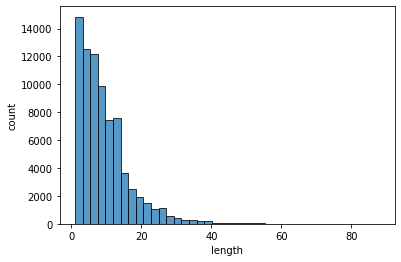

In [31]:
#Plot sentences and length
import matplotlib.pyplot as plt
ax = sns.histplot(LENS,bins=40)
ax.set(xlabel='length', ylabel='count')
plt.savefig('filename.png', dpi=300)

### Prior calculation

In [276]:
## CALCULATE PRIOR VALUES FROM THIS:

#% of fluent/repair words 
(cTAGS['F'] + repair_count)/(cTAGS['F']+cTAGS['D']+reparandum_count+repair_count)

#% of disfluent tags
cTAGS['D']/(cTAGS['F']+cTAGS['D']+reparandum_count+repair_count)

#Count number of instances of reparandum and repair occurring
reparandum_count = 0
for i in set(Ls):
    reparandum_count = reparandum_count + i.count('OP')*COUNT_DICT[i]
    
repair_count = 0
for i in set(Ls):
    repair_count = repair_count + i.count('P')*COUNT_DICT[i]

#% of reparandum tags
(reparandum_count)/(cTAGS['F']+cTAGS['D']+reparandum_count+repair_count)

0.8957749337101879

In [157]:
from collections import Counter

In [158]:
COUNT_DICT = Counter(Ls)

In [159]:
#COUNT NUMBER OF FLUENT, FILLERS and REPARANDUMS
l = 6
r = 20

count = 0
for i in set(Ls):
    if i.count('D') == 1 and i.count('O') == 0 and i.count('P') == 0:
        if len(i) < r and len(i) > l:
            count = count + COUNT_DICT[i]

print("Filler",count) #Only filler

count = 0
for i in set(Ls):
    
    if i.count('D') == 0 and i.count('O') < 3 and i.count('P') == 1:
        if len(i) < r and len(i) > l:
            count = count + COUNT_DICT[i]

print("Rpdm",count) #only rpdm

count = 0
for i in set(Ls):
    if i.count('D') == 0 and i.count('O') == 0 and i.count('P') == 0:
        if len(i) < r and len(i) > l:
                count = count + COUNT_DICT[i]

print("Fluent",count) #Only fluent

Filler 6395
Rpdm 2818
Fluent 19053


### Create DataFrame X

In [190]:
import pandas as pd

In [191]:
#Start creating dataset X: appending information on sentence number, class, sentence TAGS and length
    #Example for sentence TAGS:
#         DFFFFF for a sentence with filler in the beginning and 5 fluent words following after that

X = []

l = 6
r = 20

for j in range(0,len(Ls)):
    
    i = Ls[j]

    #Filler
    if i.count('D') == 1 and i.count('O') == 0 and i.count('P') == 0:
        if len(i) < r and len(i) > l:
            X.append(['filler',sent_keys[j],i,i.count('F')])

    #RPDM
    if i.count('D') == 0 and i.count('O') < 3 and i.count('P') == 1:
        if len(i) < r and len(i) > l:
            X.append(['rpdm',sent_keys[j],i,i.count('F') + i.count('P')])



    #Only fluent
    if i.count('D') == 0 and i.count('O') == 0 and i.count('P') == 0:
        if len(i) < r and len(i) > l:
            X.append(['fluent',sent_keys[j],i,i.count('F')])

In [192]:
#Add column names
X = pd.DataFrame(X,columns=['class','sentence_label','type','length'])

In [193]:
X['prior'] = [PRIOR[x] for x in X['class'].values]
X['duration'] = [DURATION[x] for x in X['class'].values]

### Duration calculation

In [184]:
#Calculate duration of each class
dTAGS = {}
dTAGS['F'] = [] #F is for fluent
dTAGS['D'] = [] #D is for filler
dTAGS['O'] = [] #O is for reparandum
dTAGS['P'] = [] #P is for repair
dTAGS[''] = []

In [201]:
%%time
#Parse each sentence, if duration is non-zero, append the duration value 
    #This is only for words which are not reparandums
for k in sent_keys:
    for j in SETS[k]:
        q = TAGS[TERMINALS[k.split('_')[0]][j][-1]]
        s = s + q
        cTAGS[q] = cTAGS[q] + 1
        
        dur = TERMINALS[k.split('_')[0]][j][3] - TERMINALS[k.split('_')[0]][j][2]
        
        if dur !=0:
            if q == 'O' or q == 'P':
                continue
                
            else:
                dTAGS[q].append(dur)

CPU times: user 1.28 s, sys: 0 ns, total: 1.28 s
Wall time: 1.28 s


In [198]:
# %%time
#Words which are only reparandums or repair
    #Parse each sentence, if duration is non-zero, append the duration value
    #It is important to keep this separate because we want to measure the entire length of the reparandum in 
    #a sentence; This can involved multiple words in a sentence.
    
for k in X[X['class'] == 'rpdm']['sentence_label'].values:
    time = 0
    rpdm_time = 0
    repair_time = 0
    
    for j in SETS[k]:
        q = TAGS[TERMINALS[k.split('_')[0]][j][-1]]
        s = s + q
        cTAGS[q] = cTAGS[q] + 1
        
        dur = TERMINALS[k.split('_')[0]][j][3] - TERMINALS[k.split('_')[0]][j][2]
        
        if dur !=0:
            if q == 'O': # is reparandum
                rpdm_time = rpdm_time + dur
            if q == 'P': #is repair
                repair_time = repair_time + dur
      
    if rpdm_time!=0:
        dTAGS['O'].append(rpdm_time) 
    if repair_time!=0:
        dTAGS['P'].append(repair_time)

In [218]:
#Average fluent duration
sum(dTAGS['D'])/len(dTAGS['D'])

#Average filler duration
sum(dTAGS['F'])/len(dTAGS['F'])

#Average reparandum duration
sum(dTAGS['O'])/len(dTAGS['O'])

0.2527699317738784

### Add prior, duration and sentence probability features to X

In [211]:
#Prior and duration values calculated from before

PRIOR = {}
PRIOR['fluent'] = 0.8957749337101879
PRIOR['filler'] = 0.07528737810192922
PRIOR['rpdm'] = 0.02893768818788287

DURATION = {}
DURATION['fluent'] = 0
DURATION['filler'] = 0.3560657530864195
DURATION['rpdm'] = 0.2527699317738784

In [35]:
#Usage from https://github.com/simonepri/lm-scorer
#To calculate probabilty of sentence from GPT-2
import torch
from lm_scorer.models.auto import AutoLMScorer as LMScorer

# Load model to cpu or cuda
device = "cuda:0" if torch.cuda.is_available() else "cpu"
batch_size = 1
scorer = LMScorer.from_pretrained("gpt2", device=device, batch_size=batch_size)

In [180]:
%%time
#Calculate features based on 
#     probability of sentence, speaker tag, sentence, sentence include disfluencies, disfluencies
PROBS = []
LOG_PROBS = []
SPEAKER_TAG = []
SENTENCE = []
DISF_SENTENCE = []
DISF = []

for i in X['sentence_label'].values:
    
    spk = i.split('_')[0]
    SPEAKER_TAG.append(spk)
    
    sent = ""
    disf_sent = ""
    disf = ""
    
    for j in SETS[i]:
        term = TERMINALS[spk][j]
        
        if term[0] in contractions:
            sent = sent[:-1]
            disf_sent = disf_sent[:-1]

        if term[-1] == 'fluent':
            sent = sent + term[0] + " "
            disf_sent = disf_sent + term[0] + " "
        
        if term[-1] in ('filler','rpdm','rp'):
            disf_sent = disf_sent + term[0] + " "
            disf = disf + term[0] + " "
        
    sent = sent[:-1]
    disf_sent = disf_sent[:-1]
    disf = disf[:-1]
    
    
    PROBS.append(scorer.sentence_score(sent))
    LOG_PROBS.append(scorer.sentence_score(sent,log=True))
    SENTENCE.append(sent)
    DISF_SENTENCE.append(disf_sent)
    DISF.append(disf)

In [352]:
#Add features based on probability of sentence, speaker tag, sentence, sentence include disfluencies, disfluencies
X['sent'] = SENTENCE
X['disf_sent'] = DISF_SENTENCE
X['disfluent'] = DISF
X['speaker'] = SPEAKER_TAG
X['probSent'] = PROBS
X['logprobSent'] = LOG_PROBS

In [ ]:
#Add speaker features

SEX = []
AGE = []
DIALECT = []
for i,j in X.iterrows():
    AGE.append(2023 - int(SPEAKER[j['speaker'][2:]][1]))
    SEX.append(SPEAKER[j['speaker'][2:]][0])
    DIALECT.append(SPEAKER[j['speaker'][2:]][2])

X['sex'] = SEX
X['age'] = AGE
X['dialect'] = DIALECT

In [ ]:
#Remove cases where probability of sentence is 0
X = X[X['probSent'] > 0]

## Add RSA probabilities

In [233]:
import pandas as pd
import math

import numpy as np

#### Calculate S0

In [234]:
S0 = {}

PRIOR = {}
PRIOR['fluent'] = 0.8957749337101879
PRIOR['filler'] = 0.07528737810192922
PRIOR['rpdm'] = 0.02893768818788287


for N in range(5,20):
    S0[N] = {}
    
    #Probability of fluent is (p(FLUENT))^N
    flu = math.pow(PRIOR['fluent'],N)
    
    #Probability of filler is (p(FLUENT))^N * (p(FILLER)) * N+1 
        #as there are N+1 places the filler can go to
    fil = (N+1)*PRIOR['filler']*math.pow(PRIOR['fluent'],N)
    
    #Probability of reparandum is (p(FLUENT))^N * (p(REPARANDUM)) * N+1 
        #as there are N places the reparandum can go to
    rep = (N)*PRIOR['rpdm']*math.pow(PRIOR['fluent'],N)
    
    _sum = flu+fil+rep
    
    S0[N]['fluent'] = flu/_sum
    
    S0[N]['filler'] = fil/_sum
    
    S0[N]['rpdm'] = rep/_sum

s0 = []
s0_fluent = []
s0_filler = []
s0_rpdm = []
for i,j in X.iterrows():
    s0.append(S0[j['length']][j['class']])
    s0_fluent.append(S0[j['length']]['fluent'])
    s0_filler.append(S0[j['length']]['filler'])
    s0_rpdm.append(S0[j['length']]['rpdm'])

X['S0'] = s0
X['S0_fluent'] = s0_fluent
X['S0_filler'] = s0_filler
X['S0_rpdm'] = s0_rpdm

#### Calculate L0

In [235]:
# L0 = P(sentence|disfluency) :: S0(disfluency|sentence) * P(sentence)

In [236]:
#Calculate
X['L0'] = X['S0']*X['probSent']
X['L0_fluent'] = X['S0_fluent']*X['probSent']
X['L0_filler'] = X['S0_filler']*X['probSent']
X['L0_rpdm'] = X['S0_rpdm']*X['probSent']

In [237]:
#Normalise
X['L0'] = X['L0']/X['L0'].sum()
X['L0_fluent'] = X['L0_fluent']/X['L0_fluent'].sum()
X['L0_filler'] = X['L0_filler']/X['L0_filler'].sum()
X['L0_rpdm'] = X['L0_rpdm']/X['L0_rpdm'].sum()

#### Calculate P(disfluency)

In [238]:
# P(disfluency) = S0(disfluency|sentence) * P(sentence) / L0(sentence|disfluency)

In [239]:
Disfprobs = {}

Disfprobs['fluent'] = X['S0_fluent'][0]*X['probSent'][0]/X['L0_fluent'][0]
Disfprobs['filler'] = X['S0_filler'][0]*X['probSent'][0]/X['L0_filler'][0]
Disfprobs['rpdm'] = X['S0_rpdm'][0]*X['probSent'][0]/X['L0_rpdm'][0]

#### Calculate S1

In [240]:
# Utility = log(L0) - cost(disfluency)

# Cost of disfluency = Average duration of disfluent filler/reparandum

# (Should it be average or specific?)

In [261]:
DURATION = {}
DURATION['fluent'] = 0
DURATION['filler'] = -math.log(0.3560657530864195)
DURATION['rpdm'] = -math.log(0.2527699317738784)

X['S1'] = np.exp(np.log(X['L0'].values) - X['duration'])
X['S1_fluent'] = np.exp(np.log(X['L0_fluent'].values) - DURATION['fluent'])
X['S1_filler'] = np.exp(np.log(X['L0_filler'].values) - DURATION['filler'])
X['S1_rpdm'] = np.exp(np.log(X['L0_rpdm'].values) - DURATION['rpdm'])

In [262]:
#Take sum to normalise
_sums = X['S1_filler'] + X['S1_fluent'] + X['S1_rpdm']

In [263]:
#Normalise
X['S1'] = X['S1'] / _sums
X['S1_fluent'] = X['S1_fluent'] / _sums
X['S1_filler'] = X['S1_filler'] / _sums
X['S1_rpdm'] = X['S1_rpdm'] / _sums

#### Calculate L1

In [264]:
# Utility = log(S0) - cost(sentence)

# Cost of sentence = Sentence_Length

# (Should it be average or specific?)

In [265]:
X['sent_length'] = X['sent'].str.len()

In [266]:
X['L1'] = np.exp(np.log(X['S0'].values) - np.log(X['sent_length']))
X['L1_fluent'] = np.exp(np.log(X['S0_fluent'].values) - np.log(X['sent_length']))
X['L1_filler'] = np.exp(np.log(X['S0_filler'].values) - np.log(X['sent_length']))
X['L1_rpdm'] = np.exp(np.log(X['S0_rpdm'].values) - np.log(X['sent_length']))

#Normalise
X['L1'] = X['L1']/X['L1'].sum()
X['L1_fluent'] = X['L1_fluent']/X['L1_fluent'].sum()
X['L1_filler'] = X['L1_filler']/X['L1_filler'].sum()
X['L1_rpdm'] = X['L1_rpdm']/X['L1_rpdm'].sum()

#### Calculate S2

In [267]:
# S2(disfluency|sentence) = L1(sentence|disfluency) * P(disfluency)

In [268]:
X['disf_prob'] = [Dprobs[x] for x in X['class'].values]

In [269]:
X['S2'] = X['L1']*X['disf_prob']
X['S2_fluent'] = X['L1_fluent']*Dprobs['fluent']
X['S2_filler'] = X['L1_filler']*Dprobs['filler']
X['S2_rpdm'] = X['L1_rpdm']*Dprobs['rpdm']

_sums = (X['S2_fluent'] + X['S2_filler'] + X['S2_rpdm'])
#Normalise
X['S2'] = X['S2']/_sums
X['S2_fluent'] = X['S2_fluent']/_sums
X['S2_filler'] = X['S2_filler']/_sums
X['S2_rpdm'] = X['S2_rpdm']/_sums

#### Calculate L2

In [270]:
# L2(sentence|disfluency) = S1(disfluency|sentence) * P(sentence)

In [271]:
X['L2'] = X['S1']*X['probSent']
X['L2_fluent'] = X['S1_fluent']*X['probSent']
X['L2_filler'] = X['S1_filler']*X['probSent']
X['L2_rpdm'] = X['S1_rpdm']*X['probSent']

#Normalise
X['L2'] = X['L2']/X['L2'].sum()
X['L2_fluent'] = X['L2_fluent']/X['L2_fluent'].sum()
X['L2_filler'] = X['L2_filler']/X['L2_filler'].sum()
X['L2_rpdm'] = X['L2_rpdm']/X['L2_rpdm'].sum()

## Analyse Data

In [283]:
#These are the 3 classes we look at
classes = ['fluent','filler','rpdm']

### speaker error

In [227]:
import numpy as np

In [272]:
#Calculate speaker error for different norms
    #norm = 2 is squared error
def func(norm):
    E0 = []
    E1 = []
    E2 = []
    ERROR_S0 = 0
    ERROR_S1 = 0
    ERROR_S2 = 0

    for i,j in X.iterrows():
        
        e_s0 = ERROR_S0
        e_s1 = ERROR_S1
        e_s2 = ERROR_S2
    
        N = norm
        for c in classes:
            if c == j['class']:
                ERROR_S0 = ERROR_S0 + math.pow((1 - j['S0_' + c]),N)
                ERROR_S1 = ERROR_S1 + math.pow((1 - j['S1_' + c]),N)
                ERROR_S2 = ERROR_S2 + math.pow((1 - j['S2_' + c]),N)

            else:
                ERROR_S0 = ERROR_S0 + math.pow(j['S0_' + c],N)
                ERROR_S1 = ERROR_S1 + math.pow(j['S1_' + c],N)
                ERROR_S2 = ERROR_S2 + math.pow(j['S2_' + c],N)
                
        E0.append(ERROR_S0 - e_s0)
        E1.append(ERROR_S1 - e_s1)
        E2.append(ERROR_S2 - e_s2)
        
    X['error_S0_norm'+str(rsaa)] = E0
    X['error_S1_norm'+str(rsaa)] = E1
    X['error_S2_norm'+str(rsaa)] = E2
    print(ERROR_S0,ERROR_S1,ERROR_S2)

In [273]:
func(1)

32580.041197388156 33319.326161859426 29648.463216689895


In [275]:
func(2)

15892.101187905755 15764.326166701243 14361.279475811076


In [276]:
func(50)

5.887251048498806 0.10188257559672333 17.195843650195386


In [277]:
func(1000)

1.556969861175328e-39 3.462130538638093e-71 9.01339648682504e-31


### speaker accuracy

In [278]:
#Calculate the accuracy for different classes
MARK_S0 = 0
MARK_S1 = 0
MARK_S2 = 0

PRED_S0 = []
PRED_S1 = []
PRED_S2 = []
MARKERS = []
MARKERS_LISTENER = []

for i,j in X.iterrows():


    t = classes.index(j['class'])

    #Store the class with the maximum probability
    PRED_S0.append(classes[np.argmax([j['S0_fluent'],j['S0_filler'],j['S0_rpdm']])])
    PRED_S1.append(classes[np.argmax([j['S1_fluent'],j['S1_filler'],j['S1_rpdm']])])
    PRED_S2.append(classes[np.argmax([j['S2_fluent'],j['S2_filler'],j['S2_rpdm']])])    

    #If the maximum probability class is the same as the sentence class give it a MARK (for correct prediction)
    if t == np.argmax([j['S0_fluent'],j['S0_filler'],j['S0_rpdm']]):
        MARK_S0 = MARK_S0 + 1

    if t == np.argmax([j['S1_fluent'],j['S1_filler'],j['S1_rpdm']]):
        MARK_S1 = MARK_S1 + 1

    if t == np.argmax([j['S2_fluent'],j['S2_filler'],j['S2_rpdm']]):
        MARK_S2 = MARK_S2 + 1
        
    r = ['S0'+'_' + j['class'],'S1'+'_' + j['class'],'S2'+'_' + j['class']]
    
    #Add the speaker type that predicts the correct class with the highest probability
    MARKERS.append('S' + str(np.argmax([j[r[0]],j[r[1]],j[r[2]]])))

In [279]:
#PRED_S tells the most probable class for each sentence predicted by the speaker
X['S0_pred'] = PRED_S0
X['S1_pred'] = PRED_S1
X['S2_pred'] = PRED_S2

#MARK tells the speaker type for each sentence
    #i.e. the speaker type that predicts the correct class with the highest probability
X['MARK'] = MARKERS

In [290]:
#PRINT ACCURACY
print("S0:",sum((X['class'] == X['S0_pred'])*1)/len(X))

print("S1:",sum((X['class'] == X['S1_pred'])*1)/len(X))

print("S2:",sum((X['class'] == X['S2_pred'])*1)/len(X))

S0: 0.5697491602944329
S1: 0.6470020724648038
S2: 0.6746230257986136


#### Speaker predictions of what disfluency a sentence should have

In [298]:
from collections import Counter

In [295]:
Counter(X['S0_pred'])

Counter({'filler': 6626, 'fluent': 21360})

In [307]:
# % distribution
x = list(Counter(X['S0_pred']).values())
[y/sum(x) for y in x]

[0.23676123776173802, 0.763238762238262]

In [296]:
Counter(X['S1_pred'])

Counter({'fluent': 26480, 'filler': 1506})

In [308]:
# % distribution
x = list(Counter(X['S1_pred']).values())
[y/sum(x) for y in x]

[0.9461873794039877, 0.053812620596012294]

In [297]:
Counter(X['S2_pred'])

Counter({'fluent': 27986})

In [309]:
# % distribution
x = list(Counter(X['S2_pred']).values())
[y/sum(x) for y in x]

[1.0]

#### comparing fillers of S0 and S1

In [60]:
#Probability of sentence for S0 filllers
X[(X['S0_pred'] == 'filler') & (X['class'] == 'filler')]['probSent'].mean()

1.13828234586408e-22

In [62]:
#Probability of sentence for S1 filllers
X[(X['S0_pred'] == 'filler') & (X['S1_pred'] == 'filler') & (X['class'] == 'filler')]['probSent'].mean()

4.774647398201806e-29

### listener error

In [288]:
#Calculate listener error
    #For this we need the ideal listener probabilities (coming from uniform distribution)
    #These are:
X['Li_fluent'] = (X['class'] == 'fluent')*1/sum((X['class'] == 'fluent')*1)
X['Li_filler'] = (X['class'] == 'filler')*1/sum((X['class'] == 'filler')*1)
X['Li_rpdm'] = (X['class'] == 'rpdm')*1/sum((X['class'] == 'rpdm')*1)

In [289]:
#NORM 2, LISTENER SPEAKER ERROR
N = 2
print("Fluent")
print(np.sum(np.power((X['Li_fluent'] - X['L0_fluent']).values,N)))
print(np.sum(np.power((X['Li_fluent'] - X['L1_fluent']).values,N)))
print(np.sum(np.power((X['Li_fluent'] - X['L2_fluent']).values,N)))
print()
print("Filler")
print(np.sum(np.power((X['Li_filler'] - X['L0_filler']).values,N)))
print(np.sum(np.power((X['Li_filler'] - X['L1_filler']).values,N)))
print(np.sum(np.power((X['Li_filler'] - X['L2_filler']).values,N)))
print()
print("Rpdm")
print(np.sum(np.power((X['Li_rpdm'] - X['L0_rpdm']).values,N)))
print(np.sum(np.power((X['Li_rpdm'] - X['L1_rpdm']).values,N)))
print(np.sum(np.power((X['Li_rpdm'] - X['L2_rpdm']).values,N)))

Fluent
0.18347117288843476
2.970100903624923e-05
0.18355512275034547

Filler
0.17619227289985526
0.0001252276039366388
0.17629463004355775

Rpdm
0.174326858520107
0.0003143200798717645
0.17443240508304325


### correlations

In [90]:
import seaborn as sns

In [57]:
import matplotlib.pyplot as plt

In [53]:
X['sex_M'] = (X['sex'] == 'M')*1

In [107]:
dff = X[['S0_filler','S1_filler','S2_filler','length','sent_length','age','sex_M']].corr()

In [109]:
dff.columns = ['S0','S1','S2','#words','#characters','age','sex (Male)']

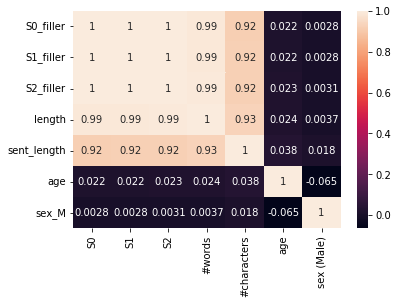

In [110]:
ax = sns.heatmap(dff, annot=True)
# ax.set(xlabel='length', ylabel='count')
plt.savefig('speakerType_correlation.png', dpi=300,bbox_inches="tight")

In [123]:
df = X[['L0_fluent','L0_filler','L0_rpdm','L1_fluent','L1_filler','L1_rpdm','L2_fluent','L2_filler','L2_rpdm']].corr()

In [124]:
df = df.round(1)

In [125]:
df.columns = ['L0 (fluent)','L0 (filler)','L0 (reparandum)','L1 (fluent)','L1 (filler)','L1 (reparandum)','L2 (fluent)','L2 (filler)','L2 (reparandum)']

In [126]:
df.index = df.columns

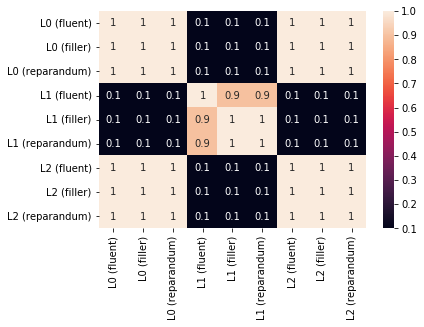

In [127]:
ax = sns.heatmap(df, annot=True)
# ax.set(xlabel='length', ylabel='count')
plt.savefig('list_correlation.png', dpi=300,bbox_inches="tight")

In [128]:
df = X[['S0_fluent','S0_filler','S0_rpdm','S1_fluent','S1_filler','S1_rpdm','S2_fluent','S2_filler','S2_rpdm']].corr()

In [129]:
df = df.round(1)

In [130]:
df.columns = ['S0 (fluent)','S0 (filler)','S0 (reparandum)','S1 (fluent)','S1 (filler)','S1 (reparandum)','S2 (fluent)','S2 (filler)','S2 (reparandum)']

In [131]:
df.index = df.columns

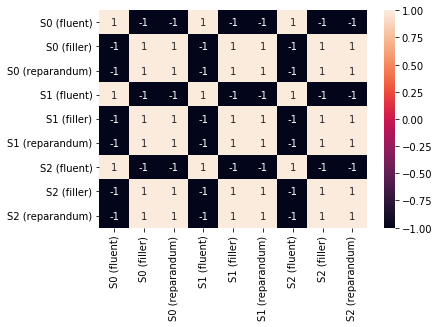

In [132]:
ax = sns.heatmap(df, annot=True)
# ax.set(xlabel='length', ylabel='count')
plt.savefig('spk_correlation.png', dpi=300,bbox_inches="tight")

In [133]:
df = X[['L0_fluent','L0_filler','L0_rpdm','L1_fluent','L1_filler','L1_rpdm','L2_fluent','L2_filler','L2_rpdm','S0_fluent','S0_filler','S0_rpdm','S1_fluent','S1_filler','S1_rpdm','S2_fluent','S2_filler','S2_rpdm']].corr()

In [134]:
df = df.round(1)

In [135]:
df.columns = ['L0 (fluent)','L0 (filler)','L0 (reparandum)','L1 (fluent)','L1 (filler)','L1 (reparandum)','L2 (fluent)','L2 (filler)','L2 (reparandum)','S0 (fluent)','S0 (filler)','S0 (reparandum)','S1 (fluent)','S1 (filler)','S1 (reparandum)','S2 (fluent)','S2 (filler)','S2 (reparandum)']

In [136]:
df.index = df.columns

In [137]:
Q = df[['S0 (filler)','S0 (reparandum)','S1 (fluent)','S1 (filler)','S1 (reparandum)','S2 (fluent)','S2 (filler)','S2 (reparandum)']][:9]

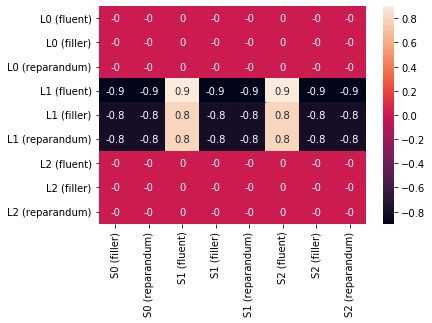

In [138]:
ax = sns.heatmap(Q, annot=True)
# ax.set(xlabel='length', ylabel='count')
plt.savefig('speakList_correlation.png', dpi=300,bbox_inches="tight")